In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from importlib import import_module
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)
ONE_HOT_LABEL = True

Using TensorFlow backend.
/home/yanxiang.zyx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yanxiang.zyx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yanxiang.zyx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yanxiang.zyx/.local/lib/python3.6/site-pa

In [2]:
def count_data(data):
    if ONE_HOT_LABEL:
        data = data.dot(np.arange(0,5)).astype('uint8')
    unique, counts = np.unique(data, return_counts=True)
    print(dict(zip(unique, counts)))

In [3]:
# # (2) Get Data
# import tflearn.datasets.oxflower17 as oxflower17
# x, y = oxflower17.load_data(one_hot=True)

DATADIR = '/Users/yanxiang.zyx/KIPRO/associative_deep_clustering/semisup/data/npy/'

dataset_tools = import_module('tools.material')

train_images, test_images, train_labels,  test_labels = dataset_tools.get_data(one_hot=ONE_HOT_LABEL, test_size=0.2)

class_names = ['Cardboard', 'Pamphlet', 'Empty', 'Plastic Foil', 'Shredded Paper']

NUM_LABELS = dataset_tools.NUM_LABELS
IMAGE_SHAPE = dataset_tools.IMAGE_SHAPE

print(train_images.shape)

count_data(train_labels)
count_data(test_labels)

(400, 227, 227, 3)
{0: 72, 1: 86, 2: 90, 3: 76, 4: 76}
{0: 28, 1: 14, 2: 10, 3: 24, 4: 24}


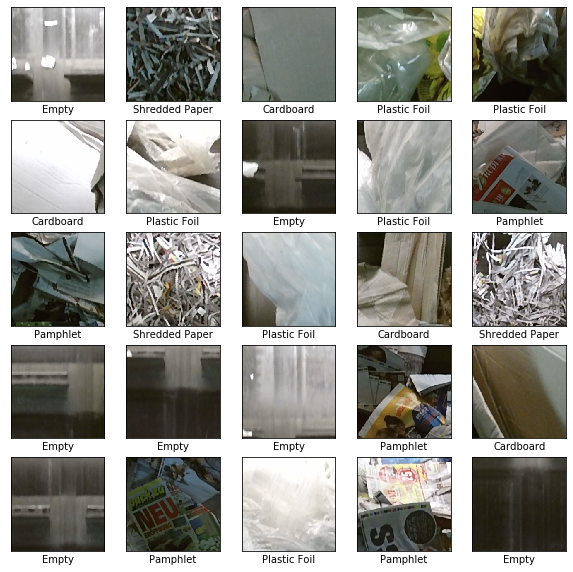

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])])
plt.show()

In [18]:
# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=IMAGE_SHAPE, kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(1024, input_shape=IMAGE_SHAPE))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))
# Batch Normalisation
# model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
# model.add(BatchNormalization())

# Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)        

In [50]:
# (4) Compile 
loss_func = 'categorical_crossentropy' if ONE_HOT_LABEL else 'sparse_categorical_crossentropy'
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy'])

In [51]:
# (5) Train
model.fit(train_images, train_labels, epochs=10, verbose=1, validation_split=0.1, shuffle=True)

Train on 360 samples, validate on 40 samples
Epoch 1/10
360/360 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.7528 - val_loss: 10.2824 - val_accuracy: 0.1750
Epoch 2/10
360/360 [==============================] - 1s 2ms/step - loss: 0.5536 - accuracy: 0.8278 - val_loss: 10.6324 - val_accuracy: 0.2500
Epoch 3/10
360/360 [==============================] - 1s 2ms/step - loss: 0.3496 - accuracy: 0.8806 - val_loss: 8.2263 - val_accuracy: 0.3000
Epoch 4/10
360/360 [==============================] - 1s 2ms/step - loss: 0.3590 - accuracy: 0.8778 - val_loss: 9.1064 - val_accuracy: 0.3500
Epoch 5/10
360/360 [==============================] - 1s 2ms/step - loss: 0.5797 - accuracy: 0.8194 - val_loss: 3.6844 - val_accuracy: 0.4000
Epoch 6/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4267 - accuracy: 0.8583 - val_loss: 119.9424 - val_accuracy: 0.1750
Epoch 7/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4182 - accuracy: 0.8778

In [52]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

100/100 [==============================] - 0s 753us/step

Test loss: 7.600309314727784

Test accuracy: 0.5099999904632568


In [53]:
predictions = model.predict(train_images)

In [54]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(NUM_LABELS))
  plt.yticks([])
  thisplot = plt.bar(range(NUM_LABELS), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

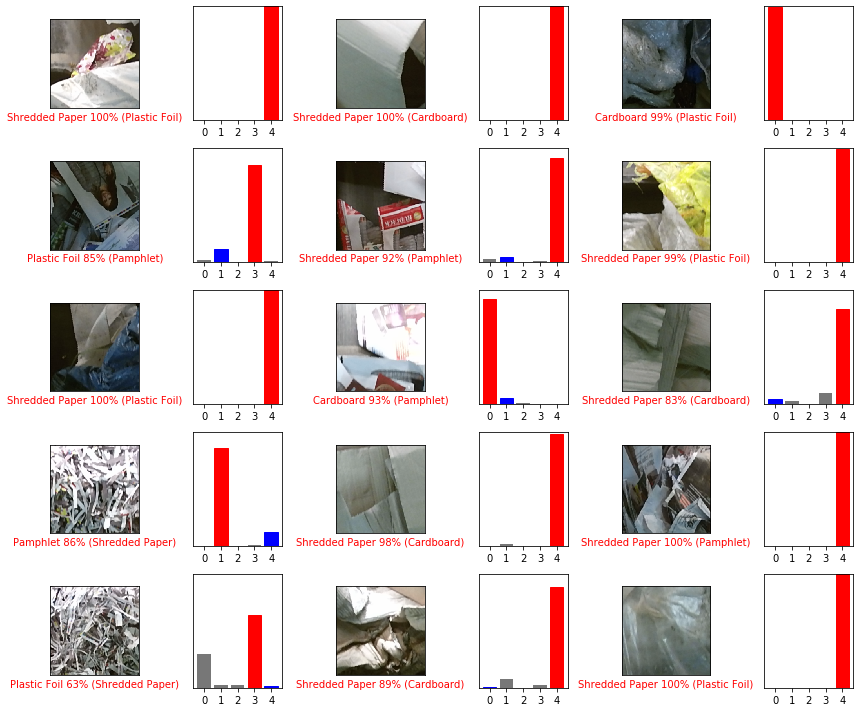

In [55]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()